# Squin gates of interest

given immutable lists `q: IList[Qubit, Literal[7]]` of qubits, and `p: float` noise rate

### Depolarizing noise channels

In [208]:
from bloqade import squin
from kirin.dialects.ilist import IList
import numpy as np
import bloqade.stim
import bloqade.tsim

In [209]:
@squin.kernel
def MSD_test():
    q = squin.qalloc(7)  # allocate qubits
    squin.u3(0,0,0,q[6])
    for i in range(6):
        squin.sqrt_y_adj(q[i])
    # [squin.broadcast.sqrt_y_adj(q[i]) for i in range(5)]
    squin.cz(q[1], q[2])
    squin.cz(q[3], q[4])
    squin.cz(q[5], q[6])
    squin.sqrt_y(q[6])
    squin.cz(q[0],q[3])
    squin.cz(q[2],q[5])
    squin.cz(q[4],q[6])
    for i in range(5):
        squin.sqrt_y(q[i+2])
    # [squin.broadcast.sqrt_y(q[i+2]) for i in range(5)]
    squin.cz(q[0],q[1])
    squin.cz(q[2],q[3])
    squin.cz(q[4],q[5])
    squin.sqrt_y(q[1])
    squin.sqrt_y(q[2])
    squin.sqrt_y(q[4])
    squin.broadcast.measure(q)

In [210]:
MSD_enc = MSD_test
stim_circ = bloqade.stim.Circuit(MSD_enc)
sampler = stim_circ.compile_sampler()
samples = sampler.sample(shots=100)
result = 1 - 2 * samples.astype(int)
import numpy as np
print(f"ExpVal:{np.mean(np.array([i[0]*i[1]*i[5] for i in result]))}")

ExpVal:1.0


In [211]:
tsim_circ = bloqade.tsim.Circuit(MSD_test)
tsim_circ.diagram(height=400)

In [212]:
def MSD_encoding(theta, phi,basis="z"):

    @squin.kernel
    def parameterized_MSD_encoding():
        q = squin.qalloc(7)  # allocate qubits
        squin.u3(theta,phi,0,q[6])
        for i in range(6):
            squin.sqrt_y_adj(q[i])
        # [squin.broadcast.sqrt_y_adj(q[i]) for i in range(5)]
        squin.cz(q[1], q[2])
        squin.cz(q[3], q[4])
        squin.cz(q[5], q[6])
        squin.sqrt_y(q[6])
        squin.cz(q[0],q[3])
        squin.cz(q[2],q[5])
        squin.cz(q[4],q[6])
        for i in range(5):
            squin.sqrt_y(q[i+2])
        # [squin.broadcast.sqrt_y(q[i+2]) for i in range(5)]
        squin.cz(q[0],q[1])
        squin.cz(q[2],q[3])
        squin.cz(q[4],q[5])
        squin.sqrt_y(q[1])
        squin.sqrt_y(q[2])
        squin.sqrt_y(q[4])
        squin.broadcast.measure(q)
    
    return parameterized_MSD_encoding

MSD_enc = MSD_encoding(np.pi, 0)
stim_circ = bloqade.stim.Circuit(MSD_enc)
sampler = stim_circ.compile_sampler()
samples = sampler.sample(shots=100)
result = 1 - 2 * samples.astype(int)
import numpy as np
print(f"ExpVal:{np.mean(np.array([i[0]*i[1]*i[5] for i in result]))}")

ExpVal:-1.0


In [213]:
phi=np.linspace(0,2*np.pi,20)
y=[]
for i in phi:
    MSD_enc = MSD_encoding(np.pi/2, i,basis="z")
    tsim_circ = bloqade.tsim.Circuit(MSD_enc)
    sampler = tsim_circ.compile_sampler()
    samples = sampler.sample(shots=1000)
    result = 1 - 2 * samples.astype(int)
    y.append(np.mean(np.array([j[0]*j[1]*j[5] for j in result])))

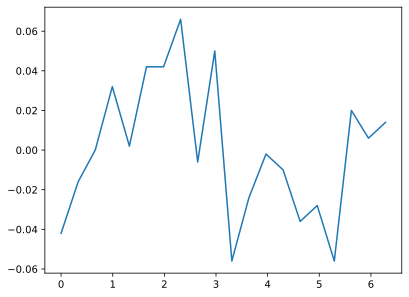

In [214]:
import matplotlib.pyplot as plt
phi=np.linspace(0,2*np.pi,20)
plt.plot(phi,y)

In [215]:
def MSD_encoding_X(theta, phi,basis="z"):

    @squin.kernel
    def parameterized_MSD_encoding():
        q = squin.qalloc(7)  # allocate qubits
        squin.u3(theta,phi,0,q[6])
        for i in range(6):
            squin.sqrt_y_adj(q[i])
        # [squin.broadcast.sqrt_y_adj(q[i]) for i in range(5)]
        squin.cz(q[1], q[2])
        squin.cz(q[3], q[4])
        squin.cz(q[5], q[6])
        squin.sqrt_y(q[6])
        squin.cz(q[0],q[3])
        squin.cz(q[2],q[5])
        squin.cz(q[4],q[6])
        for i in range(5):
            squin.sqrt_y(q[i+2])
        # [squin.broadcast.sqrt_y(q[i+2]) for i in range(5)]
        squin.cz(q[0],q[1])
        squin.cz(q[2],q[3])
        squin.cz(q[4],q[5])
        squin.sqrt_y(q[1])
        squin.sqrt_y(q[2])
        squin.sqrt_y(q[4])
        squin.broadcast.h(q)
        squin.broadcast.measure(q)
    
    return parameterized_MSD_encoding

MSD_enc = MSD_encoding_X(np.pi, 0)
stim_circ = bloqade.stim.Circuit(MSD_enc)
sampler = stim_circ.compile_sampler()
samples = sampler.sample(shots=100)
result = 1 - 2 * samples.astype(int)
import numpy as np
print(f"ExpVal:{np.mean(np.array([i[0]*i[1]*i[5] for i in result]))}")

ExpVal:-0.1


In [ ]:
phi=np.linspace(0,2*np.pi,20)
y=[]
for i in phi:
    MSD_enc = MSD_encoding_X(np.pi/2, i,basis="z")
    tsim_circ = bloqade.tsim.Circuit(MSD_enc)
    sampler = tsim_circ.compile_sampler()
    samples = sampler.sample(shots=1000)
    result = 1 - 2 * samples.astype(int)
    y.append(np.mean(np.array([j[0]*j[1]*j[5] for j in result])))

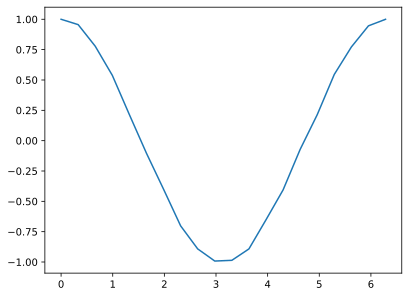

In [217]:
import matplotlib.pyplot as plt
phi=np.linspace(0,2*np.pi,20)
plt.plot(phi,y)